# Introduction to autoencoders for psychologists
#### Tutorial for Methods In Neuroscience at Dartmouth ([MIND](http://mindsummerschool.org/)) 2023
By [Mark A. Thornton](http://markallenthornton.com/)

This tutorial provides a guide to thinking about and programming autoencoders, a type of deep neural network architecture. This tutorial is designed to follow my basic introduction to programming deep nets in pytorch. If you haven't already seen that tutorial, you can find it [here](https://colab.research.google.com/drive/1VwGHNRitvehEqCe47M9J4dAQSF5KnYbg?usp=sharing).

Autoencoders are a specialized class of deep neural networks that learn compressed representations of data. To accomplish this compression, autoencoders use a characteristic "hourglass" shape illustrated below.

![](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png)

The hourglass consists of three parts:
* An encoder, which compresses the input data through layers with smaller and smaller numbers of units.
* A bottleneck layer, at the center of the network, which contains the lowest dimensional representation, or "code" for the input data.
* A decoder, which learns to expand the highly compressed code in the bottleneck back out to produce an output that reconstructs the model's inputs.

Here's we will learn about autoencoders in the context of compressing survey results, using PCA as a more familiar comparison case.


## Setup

### Import packages

In [ ]:
import urllib, os, zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from scipy.linalg import orthogonal_procrustes
from scipy.stats import zscore
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

### Detect and set hardware device
Depending on where you run your notebook, you may be able to take advantage of different hardware. If a cuda-enable graphics card is available, this will be preferred. Mac chipsets (MPS) and traditional processors (CPU) are the fallback options. On Colab, you may want to change your runtime type to take advantage of the GPU runtimes they offer.

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Prepare the data
Check if data has been downloaded; if not, do so and unzip it.

These data come from a 50-item Big Five survey collected by the Open-Source Psychometrics Project. They can be retrieved from https://openpsychometrics.org/_rawdata/ but I have rehosted them for this tutorial to avoid adding load to their server.

In [ ]:
dfiles = os.listdir("./sample_data/")
fname = 'ipip_big5.csv'
if not fname in dfiles:
  datafile = urllib.request.URLopener()
  datafile.retrieve("http://markallenthornton.com/data/ipip_big5.zip", "./sample_data/data.zip")
  with zipfile.ZipFile("./sample_data/data.zip") as zip_ref:
    zip_ref.extractall("./sample_data/")

Load the data into Python, filter out unnecessary items and observations with missing values, then transform all values to the [0,1] interval.

In [ ]:
# load data
dat = pd.read_csv('./sample_data/ipip_big5.csv', sep='\t')
dat = dat.iloc[:,:50]  # filters out variables except items
dat = dat.loc[dat.min(1)!=0,]  # filters out missing values (0s)
dat = (dat-1)/4 # transform to 0-1 scale
dat.dropna(inplace=True)
dat.shape

(874434, 50)

Reverse score the appropriate values.

In [ ]:
revd = [2, 4, 6, 8, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 32, 34, 36, 38, 42, 44, 46]
revd = [r-1 for r in revd]
for r in revd:
    dat.iloc[:,r] = 1-dat.iloc[:,r]

Split the full dataset into training (90%), validation (5%), and test (5%) sets and scale to mean = 0, SD = 1 (based on training data parameters).

In [ ]:
# split data
train = dat.sample(frac=.9,random_state=0)
testval = dat.drop(train.index)
test = testval.sample(frac=.5,random_state=0)
val = testval.drop(test.index)

# scale data
scaler = StandardScaler()
scaler.fit(train)
train = pd.DataFrame(scaler.transform(train))
test = pd.DataFrame(scaler.transform(test))
val = pd.DataFrame(scaler.transform(val))

print((train.shape[0],test.shape[0],val.shape[0]))

(786991, 43722, 43721)


Score the survey in the way that was intended (i.e., by taking the means of the subscales)

In [ ]:
# score 'appropriately' (mean of items)
trainScored = pd.concat([train.iloc[:,:10].mean(1),
             train.iloc[:,10:20].mean(1),
             train.iloc[:,20:30].mean(1),
             train.iloc[:,30:40].mean(1),
             train.iloc[:,40:50].mean(1)],axis=1)

testScored = pd.concat([test.iloc[:,:10].mean(1),
             test.iloc[:,10:20].mean(1),
             test.iloc[:,20:30].mean(1),
             test.iloc[:,30:40].mean(1),
             test.iloc[:,40:50].mean(1)],axis=1)

## Baseline

Use the means of each subscale in the training set to predict the individual question ratings in the test set. This provides baseline metrics (root mean square error [RMSE] and R<sup>2</sup>) against which to compare our later models.

In [ ]:
# compute the mean factor scores
ffmeans = trainScored.mean(axis=0)

# make predictions about the test set
ffmeanpred = np.repeat(np.ndarray((1,50),buffer=np.array(np.repeat(ffmeans,10))),test.shape[0],axis=0)

# compute metrics
rmse = np.sqrt(mean_squared_error(test,ffmeanpred))

# R2
r2 = r2_score(test,ffmeanpred)

print("RMSE = " + str(rmse) + ", R2 = " + str(r2))

RMSE = 0.9980879091702006, R2 = -2.0687293782364335e-05


Given the standardization of the data, an RMSE around 1, and R2 around 0 is what we would expect for this baseline.

## Scoring
Now let's score each participant's data individually (i.e., the way that we would actually score their Big 5 questionnaire, giving equal weight to each question within a subscale).

In [ ]:
# individual scoring performance
ffind = np.repeat(np.array(testScored),10,1)

# compute metrics
rmse = np.sqrt(mean_squared_error(test,ffind))

# R2
r2 = r2_score(test,ffind)

print("RMSE = " + str(rmse) + ", R2 = " + str(r2))

RMSE = 0.7551913272726057, R2 = 0.42766950509958934


As we might hope, scoring the Big 5 properly does a much better job than assuming the scale mean for each item. The RMSE decreases to about 3/4 of baseline error, and variance explained increases to over 40%. However, the scoring procedure assumes that each item in a subscale should be equally weighted. This works reasonably well here because that is how the scale was constructed to operate, but can we do better by dropping this assumption and using PCA instead?

## PCA
Here we perform a principal component analysis with a five-factor solution.

In [ ]:
# perform PCA on training data
trainpca = PCA(n_components=5,)
trainpca.fit(train)

PCA(n_components=5)

Next we apply this PCA to predict item-level ratings in the held-out test set.

In [ ]:
# apply PCA to test data and evaluate fit
testscores = trainpca.transform(test)
ffpca = trainpca.inverse_transform(testscores)

# compute metrics
rmse = np.sqrt(mean_squared_error(test,ffpca))

# R2
r2 = r2_score(test,ffpca)

print("RMSE = " + str(rmse) + ", R2 = " + str(r2))

RMSE = 0.731608564621871, R2 = 0.46284261823824274


The PCA does better than the scoring method in terms of both of our metrics of interest, but the difference in slight.

PCA performs a linear compression of the survey data. To see whether a nonlinear compression could perform better, we will now turn to an autoencoder

## Autoencoder
In the cell below, we define the structure of our autoencoder. It consists of ReLU layers (with the exception of the bottleneck and output layers) that decrease from 128 units to 8 units in powers of two in the decoder, followed by a 5 unit bottleneck, and then reexpansion out to 128 units before reconstructing the length 50 input as the output. Batch normalization is applied after each ReLU layer.

In [ ]:
# define model architecture
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(50,128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.BatchNorm1d(8),
            nn.Linear(8,5),
            nn.Linear(5,8),
            nn.ReLU(),
            nn.BatchNorm1d(8),
            nn.Linear(8,16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128,50)
        )

    def forward(self, x):
        pred = self.layer_stack(x)
        return pred

ae = autoencoder().to(device)

The class defined the cell below allows us to perform early stopping to prevent overfitting of the autoencoder.

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Next we set the batch size, turn our dataframes into tensors, then tensor datasets, and finally put them into dataloaders.

In [ ]:
batch_size=128

train_tensor = torch.from_numpy(np.float32(train))
train_dataset = TensorDataset(train_tensor, train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_tensor = torch.from_numpy(np.float32(test))
test_dataset = TensorDataset(test_tensor, test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

val_tensor = torch.from_numpy(np.float32(val))
val_dataset = TensorDataset(val_tensor, val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


The function below defines our training procedure for a single epoch.

In [ ]:
def train_nn(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # note that we're actually using the GPU here
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

The function below allows us to test the performance of our model on a new dataloader.

In [ ]:
# define test function
def test_nn(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, r2 = 0, 0 # evaluate loss (MSE, and R^2)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            r2 += 1 - torch.sum((y-pred)**2) / torch.sum(y **2)
    test_loss /= num_batches
    r2 /= num_batches
    print(f"Performance: \n R^2: {r2:>8f}, RMSE: {np.sqrt(test_loss):>8f} \n")
    return r2.cpu().numpy(), test_loss

Now we'll train the autoencoder.

In [ ]:
# set random seeds
torch.manual_seed(0) # pytorch's random seed
np.random.seed(0) # numpy's random seed
early_stopper = EarlyStopper(patience=1, min_delta=0)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(),lr=.001)
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_nn(train_dataloader, ae, loss, optimizer)
    val_loss = test_nn(val_dataloader, ae, loss)[1]
    if early_stopper.early_stop(val_loss):
        break
print("Done!")

Epoch 1
-------------------------------
loss: 1.381381  [  128/786991]
loss: 0.808010  [12928/786991]
loss: 0.787175  [25728/786991]
loss: 0.651829  [38528/786991]
loss: 0.699782  [51328/786991]
loss: 0.641226  [64128/786991]
loss: 0.548250  [76928/786991]
loss: 0.574619  [89728/786991]
loss: 0.592357  [102528/786991]
loss: 0.607343  [115328/786991]
loss: 0.594988  [128128/786991]
loss: 0.600100  [140928/786991]
loss: 0.566155  [153728/786991]
loss: 0.614944  [166528/786991]
loss: 0.614284  [179328/786991]
loss: 0.569217  [192128/786991]
loss: 0.598552  [204928/786991]
loss: 0.629417  [217728/786991]
loss: 0.584816  [230528/786991]
loss: 0.568159  [243328/786991]
loss: 0.572322  [256128/786991]
loss: 0.602150  [268928/786991]
loss: 0.580945  [281728/786991]
loss: 0.589399  [294528/786991]
loss: 0.583255  [307328/786991]
loss: 0.595573  [320128/786991]
loss: 0.561147  [332928/786991]
loss: 0.607054  [345728/786991]
loss: 0.588312  [358528/786991]
loss: 0.606857  [371328/786991]
loss: 0.

Now that the model is finished training, we can test it. The performance metrics indicated above reflect performance in the validation set, but that could be inflated. Using the completely held-out test set should give us an unbiased assay of autoencoder performance.

In [ ]:
test_nn(test_dataloader, ae, loss);

Performance: 
 R^2: 0.492630, RMSE: 0.710772 



As we can see, the autoencoder does outperform the PCA solution, explaining about 3%-points more of the variance in individual item responses. The differences in performance between the PCA and autoencoder are small, but similar in magnitude to the difference between the PCA and survey scoring methods. This suggests that the assumption of nonlinearity is wrong to about the same degree as the assumption of equal item weighting in this case.

## Comparing autoencoder representations to scoring

In order to use the autoencoder to encode data in its compressed 5d bottleneck space, we cut the network in half - removing the decoder so that the bottleneck layer becomes the output layer.




In [ ]:
# create encoder-only class to extract bottleneck representations
class encoder(nn.Module):
            def __init__(self):
                super().__init__()
                self.features = nn.Sequential(
                    *list(ae.layer_stack.children())[:-16]
                )
            def forward(self, x):
                x = self.features(x)
                return x
eonly = encoder()

# create representation extraction function
def ae_code(x,model):
    x = x.to(device)
    pred = model(x)
    return pred.cpu().detach().numpy()

# extract test set representation
aec = ae_code(test_tensor,eonly)

In [ ]:
# calculate out of sample correlation between rotated embedding and Big 5 scores

# preparation
aec = pd.DataFrame(aec)
zaec = aec.apply(zscore)
ztestScored = testScored.apply(zscore)

rmats = np.zeros((5,5))
n = aec.shape[0]

# learn procrutes rotation on one half of data
sel = np.random.choice(n,int(np.round(n/2)),replace=False)
R = orthogonal_procrustes(zaec.iloc[sel,],ztestScored.iloc[sel,])

# rotate other half of data
nsel = [x for x in range(n) if x not in sel]
zraec = np.dot(zaec.iloc[nsel,],R[0])

# populate correlation matrix
for i in range(5):
    for j in range(5):
        rmats[i,j] = np.corrcoef(ztestScored.iloc[nsel,i],zraec[:,j])[0,1]

<Axes: >

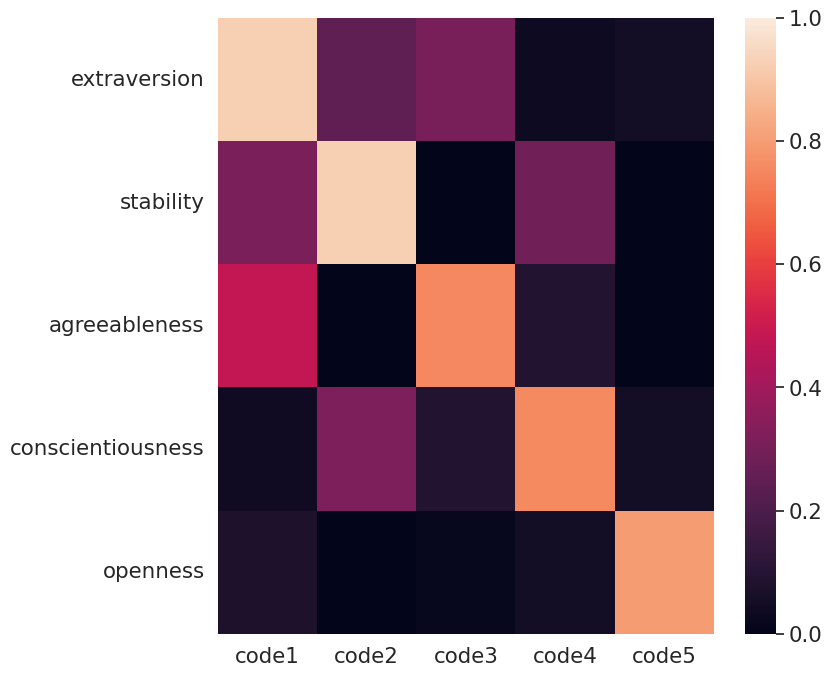

In [ ]:
# plot results
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.4)
tlabs = ['extraversion', 'stability', 'agreeableness', 'conscientiousness', 'openness']
nlabs = ['code' + str(i+1) for i in range(5)]
sns.heatmap(rmats,xticklabels=nlabs,yticklabels=tlabs,vmin=0.,vmax=1.)

## Conclusion

As we've seen, an autoencoder can learn a representation of personality very similar to that derived via PCA, as well as by the intended scoring of the IPIP Big 5 survey. The autoencoder performs slightly better at reconstructing individual item responses out of sample, but the difference is relatively small. This small difference likely reflects the fact that personality survey questions are selected for their good *linear* response properties. Items with nonlinear response properties would likely be filtered out during the scale construction process. As such, there is little benefit to using a model that can capitalize on nonlinear structure, since this structure has been excluded by design. That said, it's possible that one could construct more efficient (i.e., shorter) scales using questions with nonlinear response properties, provided that one used a model like an autoencoder, rather than a linear model like PCA or summation of ratings, to score people's responses.

If you're interested in learning more about autoencoders, the two of the most popular extensions of this method are:
* De-noising autoencoders: rather than feeding the model the exact same data as both input and output, the training inputs to a de-noising autoencoder consist of outputs with noise artificially added to them. Since the desired outputs don't have this noise, the model learns to remove the noise from the inputs (in addition to compressing them). These models can then be used to de-noise genuinely noise data, provided that the noise in the real data has the same statistical properties as the artificial noise in the training data.
* Variational autoencoders: variational autoencoders (VAEs) feature probabilistic hidden units in their bottleneck layer. This means that each of these units represents a distribution, rather than a single value. These probabilistic units allow the VAEs to become generative models, capable of producing novel outputs by interpolating within their latent bottleneck representations.